In [2]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
import ProgressMeter

In [3]:
import ReactiveMP.messageout

In [4]:
include("helpers/data.jl")
include("helpers/form_constraint.jl")

In [5]:
function NN(y_,u_,θ)
    x = [y_;u_]'*θ
    1/(1+exp(-x))
end

NN (generic function with 1 method)

In [6]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(1e-1, 1.0))}
    y       = datavar(Float64, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end]
    
    sigmoid_out = [NN(y_prev[i], u[i], params_f) for i in 1:n]

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2]) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    
    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)
    for t in 1:n

        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}

        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + sigmoid_out[t]

        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        
        h_prev = h[t]
    end

    # return variables
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [7]:
function nonlinear_max_inference(observations,observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(dim), diageye(dim)), w_prior=(1.0, 1e3), dim=2, vmp_its = 10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, dim, model_flow, params, h_prior, w_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_post = getmarginals(h)
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(h_post, (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [8]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [48]:
Random.seed!(42)

n_samples = 1000
controls_ = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 1, 1, 1
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                 Dict(:er_var=>1e0, :u=>controls_))

(Any[0.7067351815667464, 0.14919557795806077, 0.1199018265061727, 0.32948871950422753, -0.41045580262601816, -0.013852307474176677, 0.12925704318247772, -0.43098330671841667, 0.40292450905250027, 0.6212879060746075  …  -0.6093779225556317, -0.32347168513827673, -0.16458078415304012, 0.6239555018027754, 0.08282611556743706, -0.7140661379256266, -0.4613902553205891, 0.4484167668439276, 0.7357652684507563, 0.6861691274531286], [-0.444383357109696, 0.7338905195759403, -0.15028851240084978, 1.8977629245634973, -0.8154128122245925, -0.8790616847936927, 0.1422911551665636, -2.5127339648943186, 0.5723265947410677, 1.4853057146609294  …  -1.6610187935160439, -2.383210499220804, 0.5485579662838133, 0.3445635929128455, -1.7066075911397218, -1.8796910377176996, 1.462108309199898, 1.295370420130248, 0.09495071945197797, 1.314158477519317], [-0.5560268761463861, 0.027155338009193845, -0.29948409035891055, 1.7778610980573246, -1.14490153172882, -0.46860588216767457, 0.15614346264074028, -2.6419910080

In [49]:
observations_prev = y_obs[1:end-1]
observations = y_obs[2:end];
controls = controls_[order_u:end];

In [52]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

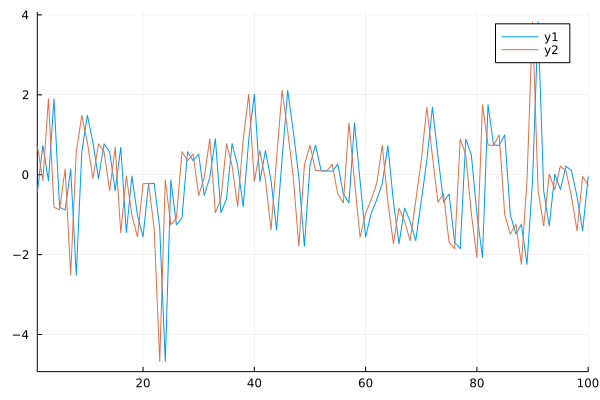

In [53]:
from, to = 1, 100
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to))

In [54]:
function FE(params)
    fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, dim=2, vmp_its=10)
    return fe[end]
end;

In [55]:
param_len = nr_params(model_flow)

12

In [62]:
fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, randn(param_len+2), dim=2, vmp_its=50);

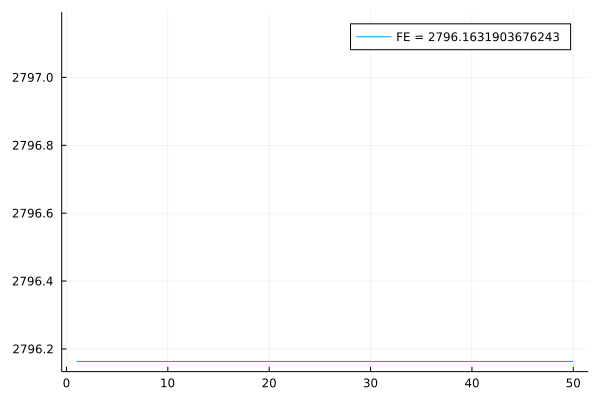

In [63]:
gr()
plot(fe, label="FE = $(fe[end])")

In [64]:
using Optim
res = optimize(FE, randn(nr_params(model_flow)+2), GradientDescent(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     2.829350e+03     1.019512e+02
 * time: 0.0001480579376220703
     1     2.822719e+03     2.501053e+02
 * time: 12.069156169891357
     2     2.717566e+03     1.451020e+02
 * time: 24.094151973724365
     3     2.695828e+03     9.846881e+01
 * time: 32.93964600563049
     4     2.680764e+03     1.751995e+02
 * time: 38.79444599151611
     5     2.668431e+03     1.072685e+02
 * time: 44.61079502105713
     6     2.662239e+03     2.382241e+02
 * time: 200.48496317863464
     7     2.657286e+03     2.216154e+02
 * time: 209.4086480140686
     8     2.655533e+03     2.232188e+02
 * time: 376.2971911430359
     9     2.653751e+03     2.214166e+02
 * time: 524.6023101806641
    10     2.645442e+03     2.160767e+02
 * time: 680.0276010036469
    11     2.645442e+03     2.160767e+02
 * time: 900.3290860652924


 * Status: success

 * Candidate solution
    Final objective value:     2.645442e+03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.16e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   900  (vs limit Inf)
    Iterations:    11
    f(x) calls:    308
    ∇f(x) calls:   308


In [65]:
1+1

2

In [66]:
inf_params = Optim.minimizer(res)
FE(inf_params)

2645.4420849261624

In [67]:
inf_params = Optim.minimizer(res)


fe, h, w = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, dim=2, vmp_its=100);

In [68]:
inv(mean(w))

1.0

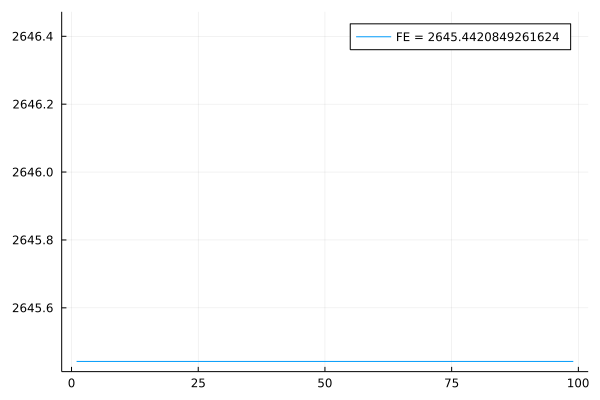

In [69]:
plot(fe[2:end], label="FE = $(fe[end])")

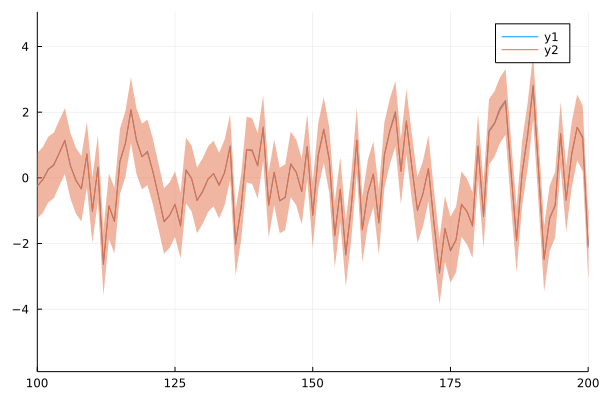

In [71]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(100, 200))
plot!(my, ribbon=sqrt.(vy))

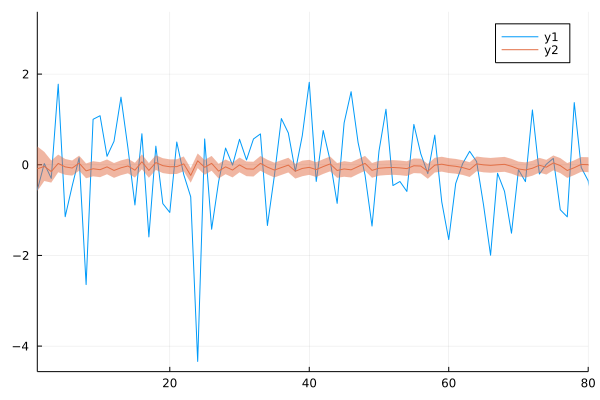

In [72]:
mh, vh = mean.(h), cov.(h)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(1, 80))

In [73]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    
    y_pred       = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end]

    θ   = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w   = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(1.0, 1.0))}

    sigmoid_pred = NN(y_prev, u, params_f)
    # @show sigmoid_pred

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2]) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    # specify observations
    
    ar_node, h ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + sigmoid_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w)
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [74]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(dim), diageye(dim)), w_prior=(1.0, 1.0), dim=2, vmp_its = 50) where T<:Float64

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(dim, model_flow, params, h_prior, w_prior,
                                                                                              observation_prev, control,
                                                                                              options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    y_out_buffer = nothing
    w_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [75]:
(mean(h[end]), precision(h[end]))
(shape(w), rate(w))
# inv(mean(w))

(1.0, 1.0)

In [80]:
predictions = []
h_pred = (mean(h[end]), precision(h[end]))
w_pred = (shape(w), rate(w))
rw = []
for i in 1:length(X_test)
    fe, h_pred_, w_pred_, y_pred = nonlinear_max_prediction(X_test[i], Float64(1e-4), model_flow, inf_params, h_prior=h_pred, w_prior=w_pred, dim=2, vmp_its=100)
    push!(predictions, y_pred)
    h_pred = (mean(h_pred_), precision(h_pred_))
    push!(rw, [mean(h_pred_)[1], cov(h_pred_)[1]])
end

In [81]:
mx, vx = mean.(predictions), cov.(predictions)

([1.867428676685991, 2.005260829915519, 2.2142694095567905, 2.32990407287765, 2.3222751783759903, 1.9738150754601, 2.2772297868187836, 2.1114737452641106, 2.3520158151702413, 2.045380050554139  …  2.0192126982675367, 2.294541178388187, 2.359546277103317, 2.0013503399521624, 2.0300024862077826, 2.299243656881658, 2.3163601449530464, 1.8856804099681672, 1.9048018329792453, 2.0657156563906334], [0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999  …  0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999, 0.9999999999989999])

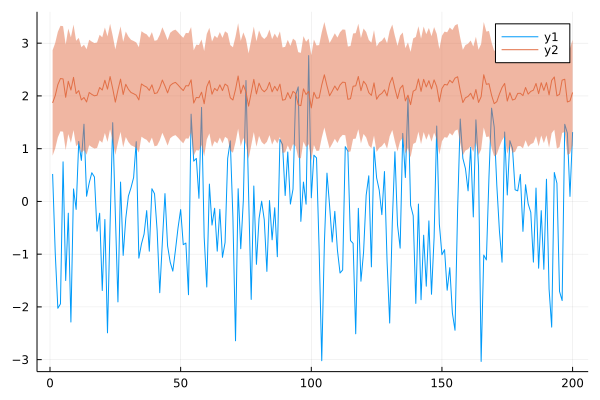

In [82]:
plot(Y_test)
plot!(mx, ribbon=sqrt.(vx))

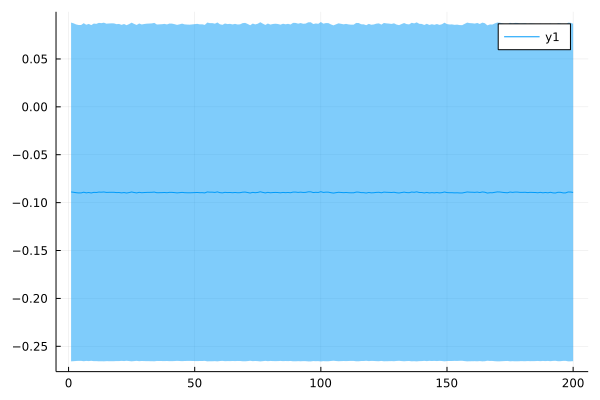

In [83]:
plot(first.(rw), ribbon=sqrt.(last.(rw)))